# Multiple Linear Regression

In [1]:
## Import required packages

%matplotlib inline
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

## Setup the predictors to use

In [2]:
car_df = pd.read_csv('datasets/ToyotaCorolla.csv')
print(car_df.head())

predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=9)

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))

   Id                                          Model  Price  Age_08_04  \
0   1  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13500         23   
1   2  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13750         23   
2   3  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13950         24   
3   4  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  14950         26   
4   5    TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors  13750         30   

   Mfg_Month  Mfg_Year     KM Fuel_Type  HP  Met_Color  ... Powered_Windows  \
0         10      2002  46986    Diesel  90          1  ...               1   
1         10      2002  72937    Diesel  90          1  ...               0   
2          9      2002  41711    Diesel  90          1  ...               0   
3          7      2002  48000    Diesel  90          0  ...               0   
4          3      2002  38500    Diesel  90          0  ...               1   

   Power_Steering  Radio  Mistlamps  Sport_Model  Backseat_Divider  \
0         

In [3]:
pred_y = car_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

adjusted r2 :  0.8713150432593038
AIC :  14813.451494097324
BIC :  14875.306722654885


## Make predictions for validation data and show residuals

In [4]:
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

         Predicted  Actual     Residual
323   12357.034811   11250 -1107.034811
1388   8139.301799    8750   610.698201
1148   6188.900720    6750   561.099280
59    15682.160845   15999   316.839155
613    7928.954085    7950    21.045915
855    8978.945899    8950   -28.945899
335   13382.237055   12500  -882.237055
1419   8751.353262    8450  -301.353262
489   11349.448496    9940 -1409.448496
686    9320.909721    8950  -370.909721
1343   8684.008838    8450  -234.008838
634   11266.144223    8950 -2316.144223
629    8697.517049    7750  -947.517049
39    15739.000449   14750  -989.000449
131   16748.738883   15950  -798.738883
1302   7906.715170    7450  -456.715170
1092   7346.708370    7250   -96.708370
358   13493.016742   12750  -743.016742
1347   8471.778942    7450 -1021.778942
958    8926.613957    8950    23.386043

Regression statistics

                      Mean Error (ME) : -55.6439
       Root Mean Squared Error (RMSE) : 1281.1812
            Mean Absolute Error (MAE)

## Determine the residuals and create a histogram

Percentage 0.7739130434782608


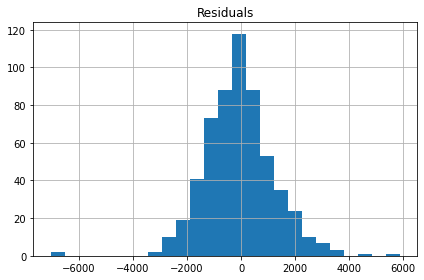

In [5]:
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print('Percentage', len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))
# print(all_residuals[(all_residuals > 25000)])

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)
plt.tight_layout()
plt.show()

## Table 6.5
Run an exhaustive search. The Fuel type column is categorical and needs to be converted into dummy variables.

In [6]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj           AIC  Age_08_04  Automatic     CC  Doors  Fuel_Type_Diesel  \
0    1  0.768909  15307.600709       True      False  False  False             False   
1    2  0.802709  15172.445461       True      False  False  False             False   
2    3  0.848618  14945.388968       True      False  False  False             False   
3    4  0.861114  14872.202174       True      False  False  False             False   
4    5  0.863656  14857.290030       True      False   True  False             False   
5    6  0.866380  14840.908156       True      False   True  False             False   
6    7  0.867365  14835.528484       True      False   True  False              True   
7    8  0.870635  14815.025439       True      False   True  False              True   
8    9  0.871204  14812.217957       True       True   True  False              True   
9   10  0.871318  14812.442763       True       True   True  False              True   
10  11  0.871315  14813.451494  

## Table 6.6 backward elimination

In [7]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=14813.45
Step: score=14812.44, remove Doors
Step: score=14812.22, remove Met_Color
Step: score=14812.22, remove None
['Age_08_04', 'KM', 'HP', 'Automatic', 'CC', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol']


In [8]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : -51.6823
       Root Mean Squared Error (RMSE) : 1277.1360
            Mean Absolute Error (MAE) : 945.7838
          Mean Percentage Error (MPE) : -1.3598
Mean Absolute Percentage Error (MAPE) : 9.3475


## Table 6.7 Forward selection

In [9]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=16567.92, constant
Step: score=15307.60, add Age_08_04
Step: score=15172.45, add HP
Step: score=15055.00, add Weight
Step: score=14872.20, add KM
Step: score=14857.29, add CC
Step: score=14840.91, add Quarterly_Tax
Step: score=14835.53, add Fuel_Type_Diesel
Step: score=14815.03, add Fuel_Type_Petrol
Step: score=14812.22, add Automatic
Step: score=14812.22, add None
['Age_08_04', 'HP', 'Weight', 'KM', 'CC', 'Quarterly_Tax', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Automatic']


In [10]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=16567.92, constant
Step: score=15307.60, add Age_08_04
Step: score=15172.45, add HP
Step: score=15055.00, add Weight
Step: score=14872.20, add KM
Step: score=14857.29, add CC
Step: score=14840.91, add Quarterly_Tax
Step: score=14835.53, add Fuel_Type_Diesel
Step: score=14815.03, add Fuel_Type_Petrol
Step: score=14812.22, add Automatic
Step: score=14812.22, unchanged None
['Age_08_04', 'HP', 'Weight', 'KM', 'CC', 'Quarterly_Tax', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Automatic']


## Regularizization methods

In [11]:
print('Car To Predict')
car_to_predict = np.array([
                            [23, 45000, 90, 1, 0, 2000, 3, 210, 1165, 1, 0],    # CONTROL CASE
                            [23, 25000, 90, 1, 0, 2000, 3, 210, 1165, 1, 0],    # less miles
                            [12, 70000, 90, 1, 0, 2000, 3, 210, 1165, 1, 0],    # older
                            [23, 45000, 90, 1, 0, 2000, 3, 210, 1165, 0, 1],    # not diesel, petrol
                            [23, 45000, 90, 1, 0, 2000, 3, 210, 1165, 0, 0],    # not diesel, cng
                            [23, 45000, 110, 1, 0, 2000, 3, 210, 1165, 1, 0],   # more horsepower
                            [23, 45000, 90, 1, 0, 1100, 3, 210, 1165, 1, 0],   # smaller engine
                            [23, 45000, 90, 1, 0, 2000, 5, 210, 1165, 1, 0],   # more doors
                        ])
print(car_to_predict, '\n\n')

print('\n\nLasso')
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))
print(lasso.predict(car_to_predict))

print('\n\nLasso Cross-Validation')
lasso_cv = LassoCV(normalize=True, cv=100)
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('\n\nLasso-CV chosen regularization: ', lasso_cv.alpha_)
print('\n\nLasso coefficients', lasso_cv.coef_)
print(lasso_cv.predict(car_to_predict))

print('\n\nRidge')
ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))
print(ridge.predict(car_to_predict))

print('\n\nBayesianRidge')
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', bayesianRidge.lambda_ / bayesianRidge.alpha_)
print(bayesianRidge.predict(car_to_predict))

Car To Predict
[[   23 45000    90     1     0  2000     3   210  1165     1     0]
 [   23 25000    90     1     0  2000     3   210  1165     1     0]
 [   12 70000    90     1     0  2000     3   210  1165     1     0]
 [   23 45000    90     1     0  2000     3   210  1165     0     1]
 [   23 45000    90     1     0  2000     3   210  1165     0     0]
 [   23 45000   110     1     0  2000     3   210  1165     1     0]
 [   23 45000    90     1     0  1100     3   210  1165     1     0]
 [   23 45000    90     1     0  2000     5   210  1165     1     0]] 




Lasso

Regression statistics

                      Mean Error (ME) : -39.9506
       Root Mean Squared Error (RMSE) : 1310.2447
            Mean Absolute Error (MAE) : 960.4061
          Mean Percentage Error (MPE) : -1.3379
Mean Absolute Percentage Error (MAPE) : 9.4863
[16493.15300007 16897.54563357 17311.58979539 17169.27170058
 16493.15300007 17060.04550047 17397.12757801 16403.72095686]


Lasso Cross-Validation

Regre

In [12]:
linearRegression = LinearRegression(normalize=True).fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -55.6439
       Root Mean Squared Error (RMSE) : 1281.1812
            Mean Absolute Error (MAE) : 950.8663
          Mean Percentage Error (MPE) : -1.4186
Mean Absolute Percentage Error (MAPE) : 9.4147


In [13]:
pd.DataFrame({'features': train_X.columns, 
              'linear regression': linearRegression.coef_, 
              'lassoCV': lasso_cv.coef_, 
              'ridge': ridge.coef_, 
              'bayesianRidge': bayesianRidge.coef_})

,features,linear regression,lassoCV,ridge,bayesianRidge
0,Age_08_04,-120.342795,-119.429623,-64.552326,-119.985828
1,KM,-0.018881,-0.020264,-0.019410,-0.019070
2,HP,54.755205,22.674972,22.728383,52.525809
3,Met_Color,134.653818,0.000000,212.746177,133.720431
4,Automatic,429.862561,0.000000,277.049507,420.039942
5,CC,-3.803782,-0.000000,0.142231,-3.580825
6,Doors,-51.624453,-0.000000,86.064625,-54.434143
7,Quarterly_Tax,11.518299,0.000000,4.698903,11.297397
8,Weight,17.930404,15.542518,12.589538,18.093039
9,Fuel_Type_Diesel,3127.650123,-0.000000,-8.472801,2862.074767


## Table 6.10

In [14]:
# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Price ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     530.4
Date:                Wed, 03 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:44:52   Log-Likelihood:                -7393.7
No. Observations:                 861   AIC:                         1.481e+04
Df Residuals:                     849   BIC:                         1.487e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3273.5683   1736.410  